In [1]:
from cmws.examples.scene_understanding.models import scene_understanding
import matplotlib.pyplot as plt
import math
import numpy as np
import torch
import cmws.examples.scene_understanding.render

In [24]:
device = "cuda"
num_grid_rows, num_grid_cols, num_primitives, max_num_blocks = 3, 3, 3, 3
shape = [2, 3]

generative_model = scene_understanding.GenerativeModel(num_grid_rows, num_grid_cols, num_primitives, 
                                                       max_num_blocks, im_size=512)

generative_model.primitives[0].color = torch.tensor([1., 0., 0.], device=device)
generative_model.primitives[0].size = torch.tensor(0.3, device=device)
generative_model.primitives[1].color = torch.tensor([0., 1., 0.], device=device)
generative_model.primitives[1].size = torch.tensor(0.4, device=device)
generative_model.primitives[2].color = torch.tensor([0., 0., 1.], device=device)
generative_model.primitives[2].size = torch.tensor(0.5, device=device)
generative_model.sigma.data = torch.tensor(1e-10, device=device)
generative_model.gamma.data = torch.tensor(1e-10, device=device)

def latent_to_str(latent):
    primitive_id_to_str = {0: "R", 1: "G", 2: "B"}
    num_blocks, stacking_program, raw_locations = latent
    num_grid_rows, num_grid_cols, max_num_blocks = stacking_program.shape
    locations = cmws.examples.scene_understanding.render.convert_raw_locations_batched(
        raw_locations,
        stacking_program,
        generative_model.primitives
    ).view(num_grid_rows, num_grid_cols, max_num_blocks, 3)
    latent_str = []
    for row in reversed(range(num_grid_rows)):
        tmp = []
        for col in reversed(range(num_grid_cols)):
#             s = ["." for _ in range(max_num_blocks)]
            s = []
            for block_id in range(num_blocks[row, col]):
                primitive_id = stacking_program[row, col, block_id].item()
                primitive_str = primitive_id_to_str[primitive_id]
                loc = locations[row, col, block_id]
                s.append(f"{primitive_str}({loc[0].item():.1f}, {loc[1].item():.1f}, {loc[2].item():.1f})")
#             s[:num_blocks[row, col]] = "".join(
#                 [primitive_id_to_str[x.item()] for x in stacking_program[row, col, :num_blocks[row, col]]]
#             )
            tmp.append("".join(s))
        latent_str.append(" | ".join(tmp))

    return "\n".join(latent_str)

def latent_to_str_with_locations(latent):
    primitive_id_to_str = {0: "R", 1: "G", 2: "B"}
    num_blocks, stacking_program, raw_locations = latent
    num_grid_rows, num_grid_cols, max_num_blocks = stacking_program.shape
    locations = cmws.examples.scene_understanding.render.convert_raw_locations_batched(
        raw_locations,
        stacking_program,
        generative_model.primitives
    ).view(num_grid_rows, num_grid_cols, max_num_blocks, 3)
    latent_str = []
    for row in reversed(range(num_grid_rows)):
        tmp = []
        for col in reversed(range(num_grid_cols)):
            s = []
            for block_id in range(num_blocks[row, col]):
                primitive_id = stacking_program[row, col, block_id].item()
                primitive_str = primitive_id_to_str[primitive_id]
                loc = locations[row, col, block_id]
                s.append(f"{primitive_str}({loc[0].item():.1f}, {loc[1].item():.1f}, {loc[2].item():.1f})")
#             s[:num_blocks[row, col]] = "".join(
#                 [primitive_id_to_str[x.item()] for x in stacking_program[row, col, :num_blocks[row, col]]]
#             )
            tmp.append("".join(s))
        latent_str.append(" | ".join(tmp))

    return "\n".join(latent_str)


def plot_latent_obs(latent, obs):
    fig, ax = plt.subplots(1, 1)
    ax.imshow(obs.permute(1, 2, 0).detach().cpu())
#     ax.text(
#         0.95,
#         0.95,
#         latent_to_str(latent),
#         transform=ax.transAxes,
#         fontsize=12,
#         va="top",
#         ha="right",
#         color="black",
#     )
    plt.show()

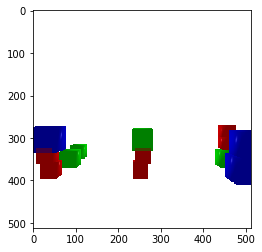

G(1.8, -1.0, 2.0) | R(-0.2, -1.0, 2.0)G(-0.3, -0.7, 2.0) | 
G(1.7, -1.0, 1.0) |  | G(-2.3, -1.0, 1.0)R(-2.3, -0.6, 1.0)R(-2.3, -0.3, 1.0)
R(1.6, -1.0, 0.0)R(1.7, -0.7, 0.0)B(1.7, -0.4, 0.0) | R(-0.1, -1.0, 0.0)R(-0.2, -0.7, 0.0)G(-0.2, -0.4, 0.0) | B(-2.2, -1.0, 0.0)B(-2.3, -0.5, 0.0)


In [26]:
latent, obs = generative_model.sample()
num_blocks, stacking_program, raw_locations = latent
plot_latent_obs(latent, obs)
print(latent_to_str(latent))

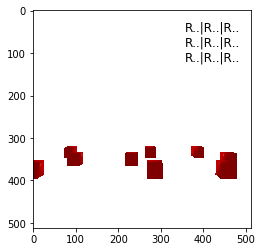

In [4]:
num_blocks = torch.ones(num_grid_rows, num_grid_cols, device=device).long()
stacking_program = torch.zeros(num_grid_rows, num_grid_cols, max_num_blocks, device=device).long()
raw_locations = 10 * torch.randn(num_grid_rows, num_grid_cols, max_num_blocks, device=device)
latent = num_blocks, stacking_program, raw_locations
obs = generative_model.get_obs_loc(latent).detach()

plot_latent_obs(latent, obs)

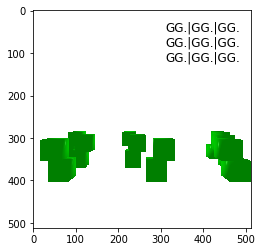

In [5]:
num_blocks = 2 * torch.ones(num_grid_rows, num_grid_cols, device=device).long()
stacking_program = torch.ones(num_grid_rows, num_grid_cols, max_num_blocks, device=device).long()
raw_locations = 10 * torch.randn(num_grid_rows, num_grid_cols, max_num_blocks, device=device)
latent = num_blocks, stacking_program, raw_locations
obs = generative_model.get_obs_loc(latent).detach()

plot_latent_obs(latent, obs)

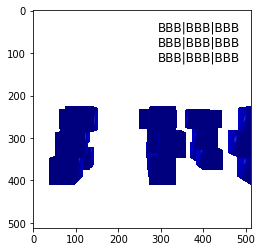

In [6]:
num_blocks = 3 * torch.ones(num_grid_rows, num_grid_cols, device=device).long()
stacking_program = 2 * torch.ones(num_grid_rows, num_grid_cols, max_num_blocks, device=device).long()
raw_locations = 10 * torch.randn(num_grid_rows, num_grid_cols, max_num_blocks, device=device)
latent = num_blocks, stacking_program, raw_locations
obs = generative_model.get_obs_loc(latent).detach()

plot_latent_obs(latent, obs)